## Data Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

# Read Data
df_model = pd.read_csv('df_model.csv')

# Distribution of Failures
print("# Failure Instances -- ", df_model.loc[df_model['FLG_FAIL']==1, ['DATE']].nunique())
plt.plot(range(df_model.shape[0]), df_model['FLG_FAIL']) # There is a period of close failures in the data.

# Failure Instances --  DATE    20
dtype: int64


### Data Processing Steps -

1. Function - Shift flag fail by n timestamps (n= # timestamps before failure when prediction should happen)
2. Remove records with actual failure - we dont want model to learn from sensor data corresponding to failure

In [2]:
df_model.drop(['DATE', 'TIMESTAMP', 'TIME_SLOT_HR', 'TIME_SLOT_MIN'], axis=1, inplace=True)

train_indx = range(0, 60000)
val_indx = range(60000, 75000)
test_indx = range(75000, df_model.shape[0])

# Normalize numeric columns
num_cols = df_model.columns[df_model.dtypes =='float64']

mean = df_model.loc[train_indx, num_cols].mean(axis = 0)
sd = df_model.loc[train_indx, num_cols].std(axis = 0)
df_model[num_cols] = df_model[num_cols] - mean
df_model[num_cols] = df_model[num_cols]/sd


# Function to shift y values
sign = lambda x: (1, -1)[x < 0]
def fn_data_shift(data, shift=-72, ycol='FLG_FAIL', out_col='FLG_FAIL_SHIFTED'):
    vec = data[ycol].copy()
    
    for i in range(abs(shift)):
        temp = vec.shift(sign(shift))
        temp = temp.fillna(0)
        vec = vec + temp
    
    data[out_col] = vec
    data.loc[data[out_col]>0, out_col] = 1
    
    return data

In [3]:
df_model_shifted = fn_data_shift(data=df_model, shift=-144) # Aim to Predict 1 day before failure

# Drop data for original failure
rwdrop_indx = df_model_shifted[df_model_shifted['FLG_FAIL']==1].index
df_model_shifted = df_model_shifted.drop(rwdrop_indx)
df_model_shifted.drop('FLG_FAIL', axis=1, inplace=True) # Drop original column

df_model_shifted.shape

(108379, 110)

In [4]:
# divide data into train/test/valid

train_indx = range(0, 60000)
val_indx = range(60000, 75000)
test_indx = range(75000, df_model_shifted.shape[0])

df_train = df_model_shifted.iloc[train_indx]
df_val = df_model_shifted.iloc[val_indx]
df_test = df_model_shifted.iloc[test_indx]

# Separate 0/1 instances for auto encoder approach
df_train_x0 = df_train.loc[df_train['FLG_FAIL_SHIFTED']==0, df_train.columns !='FLG_FAIL_SHIFTED']
df_train_y0 = df_train.loc[df_train['FLG_FAIL_SHIFTED']==0, 'FLG_FAIL_SHIFTED']
df_train_x1 = df_train.loc[df_train['FLG_FAIL_SHIFTED']==1, df_train.columns !='FLG_FAIL_SHIFTED']
df_train_y1 = df_train.loc[df_train['FLG_FAIL_SHIFTED']==1, 'FLG_FAIL_SHIFTED']

df_val_x0 = df_val.loc[df_val['FLG_FAIL_SHIFTED']==0, df_val.columns !='FLG_FAIL_SHIFTED']
df_val_y0 = df_val.loc[df_val['FLG_FAIL_SHIFTED']==0, 'FLG_FAIL_SHIFTED']
df_val_x1 = df_val.loc[df_val['FLG_FAIL_SHIFTED']==1, df_val.columns !='FLG_FAIL_SHIFTED']
df_val_y1 = df_val.loc[df_val['FLG_FAIL_SHIFTED']==1, 'FLG_FAIL_SHIFTED']

df_test_x0 = df_test.loc[df_test['FLG_FAIL_SHIFTED']==0, df_test.columns !='FLG_FAIL_SHIFTED']
df_test_y0 = df_test.loc[df_test['FLG_FAIL_SHIFTED']==0, 'FLG_FAIL_SHIFTED']
df_test_x1 = df_test.loc[df_test['FLG_FAIL_SHIFTED']==1, df_test.columns !='FLG_FAIL_SHIFTED']
df_test_y1 = df_test.loc[df_test['FLG_FAIL_SHIFTED']==1, 'FLG_FAIL_SHIFTED']

print(df_train_x0.shape, df_train_y0.shape, df_train_x1.shape, df_train_y1.shape)
print(df_val_x0.shape, df_val_y0.shape, df_val_x1.shape, df_val_y1.shape)
print(df_test_x0.shape, df_test_y0.shape, df_test_x1.shape, df_test_y1.shape)

(58128, 109) (58128,) (1872, 109) (1872,)
(14568, 109) (14568,) (432, 109) (432,)
(32947, 109) (32947,) (432, 109) (432,)


## Basic Auto encoder classification



In [5]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

encoding_dim=32
in_dim = df_train_x0.shape[-1]

input_layer = Input(shape=(in_dim,))
encoder = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(0.001))(input_layer)
encoder = Dense(int(encoding_dim/2), activation='relu')(encoder)
decoder = Dense(int(encoding_dim/2), activation='relu')(encoder)
decoder = Dense(in_dim, activation='linear')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 109)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3520      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 109)               1853      
Total params: 6,173
Trainable params: 6,173
Non-trainable params: 0
_________________________________________________________________


In [6]:
autoencoder.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')

history = autoencoder.fit(df_train_x0, df_train_x0,
               epochs=30,
               batch_size = 128,
               validation_data=(df_val_x0, df_val_x0))

Train on 58128 samples, validate on 14568 samples
Epoch 1/30
58128/58128 [==============================] - 4s 69us/step - loss: 0.3138 - acc: 5.1610e-05 - val_loss: 1.8425 - val_acc: 0.0000e+00
Epoch 2/30
58128/58128 [==============================] - 3s 49us/step - loss: 0.2160 - acc: 0.0000e+00 - val_loss: 1.8190 - val_acc: 0.0000e+00
Epoch 3/30
58128/58128 [==============================] - 3s 48us/step - loss: 0.2152 - acc: 0.0000e+00 - val_loss: 1.7886 - val_acc: 0.0000e+00
Epoch 4/30
58128/58128 [==============================] - 3s 50us/step - loss: 0.2144 - acc: 0.0000e+00 - val_loss: 1.7258 - val_acc: 0.0000e+00
Epoch 5/30
58128/58128 [==============================] - 3s 48us/step - loss: 0.2132 - acc: 0.0000e+00 - val_loss: 1.6307 - val_acc: 0.0000e+00
Epoch 6/30
58128/58128 [==============================] - 3s 50us/step - loss: 0.2114 - acc: 0.0000e+00 - val_loss: 1.4939 - val_acc: 0.0000e+00
Epoch 7/30
58128/58128 [==============================] - 3s 47us/step - loss: 0

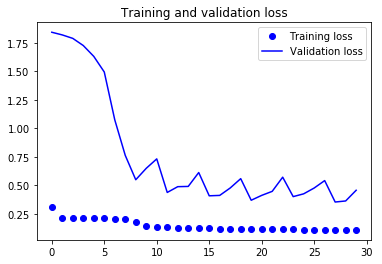

In [7]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

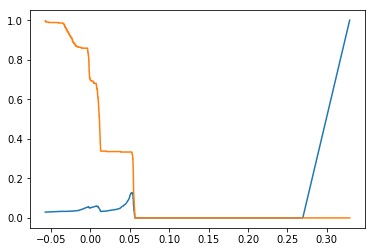

In [8]:
# Get cutoff

val_predict = autoencoder.predict(df_val.loc[:, df_val.columns !='FLG_FAIL_SHIFTED'])
mse = np.mean(np.power(df_val.loc[:, df_val.columns !='FLG_FAIL_SHIFTED'] - val_predict, 1), axis=1)

df_error = pd.DataFrame({'RECONSTRUCTION_ERROR':mse, 'TRUE_CLASS':df_val['FLG_FAIL_SHIFTED']})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(df_error['TRUE_CLASS'], df_error['RECONSTRUCTION_ERROR'])
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
#plt.xlim(0, 1)
plt.show()

# cutoff - 0.07

In [9]:
test_pred = autoencoder.predict(df_test_x0.loc[:, df_test_x0.columns!='FLG_FAIL_SHIFTED'])
mse = np.mean(np.power(df_test_x0.loc[:, df_test_x0.columns!='FLG_FAIL_SHIFTED']-test_pred, 1), axis=1)

df_error_test = pd.DataFrame({'RECONSTRUCTION_ERROR':mse, 'TRUE_CLASS':df_test['FLG_FAIL_SHIFTED']})
cutoff = 0.05

pred = [1 if error > cutoff else 0 for error in df_error_test['RECONSTRUCTION_ERROR'].values]
confusion_matrix(df_error_test['TRUE_CLASS'], pred)

array([[23417,  9530],
       [  432,     0]])